## Segmentación de Clientes usando K-means


In [ ]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
plt.rcParams.update({'font.size': 16})
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype    
datosI= pd.read_csv(r"https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv")

Quitamos la variable CustomerID, pues no tiene valor en nuestro análisis


In [ ]:
datos=datosI.drop(columns=['CustomerID'])

In [ ]:
plt.close('all')

In [ ]:
datos['Genero'] = datos['Genre']
datos['Edad'] = datos['Age']
datos['IngresoAnual (k$)'] = datos['Annual Income (k$)'] 
datos['PuntajeGasto(1-100)'] = datos['Spending Score (1-100)']

In [ ]:
datos = datos.drop(columns=['Age'])
datos = datos.drop(columns=['Genre'])
datos = datos.drop(columns=['Annual Income (k$)'])
datos = datos.drop(columns=['Spending Score (1-100)'])  

Calculamos los estadísticos de cada variable numérica

In [ ]:
datos.describe()

,Edad,IngresoAnual (k$),PuntajeGasto(1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Graficamos un diagrama de barras para las variables categóricas y un histograma junto a su función de densidad para las variables numéricas

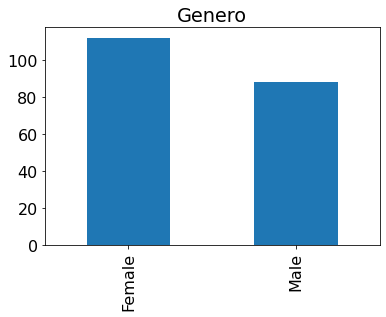

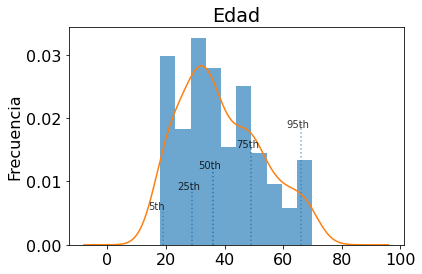

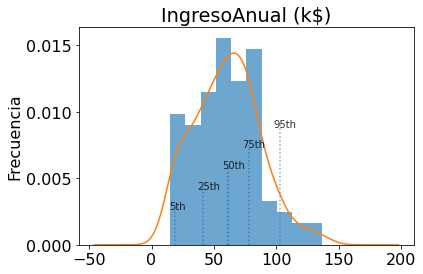

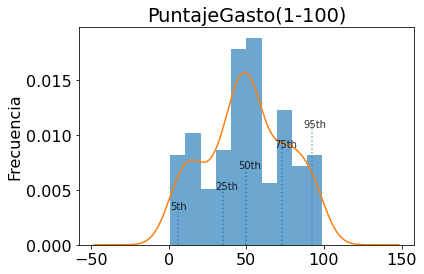

In [ ]:
for column in datos:
    fig, ax = plt.subplots(figsize = (6,4))
    plt.title(column)
    if is_numeric_dtype(datos[column]):
        n, bins, patches =ax.hist(datos[column],density = True, alpha = 0.65)  
        datos[column].plot(kind = "kde")
        ax.set_ylabel("Frecuencia")
        quant_5, quant_25, quant_50, quant_75, quant_95 = datos[column].quantile(0.05), datos[column].quantile(0.25), datos[column].quantile(0.5), datos[column].quantile(0.75), datos[column].quantile(0.95)
        quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
        ax.text(quant_5-5, 0.17*n.max(), "5th", size = 10, alpha = 0.8)
        ax.text(quant_25-5, 0.27*n.max(), "25th", size = 10, alpha = 0.8)
        ax.text(quant_50-5, 0.37*n.max(), "50th", size = 10, alpha = 0.8)
        ax.text(quant_75-5, 0.47*n.max(), "75th", size = 10, alpha = 0.8)
        ax.text(quant_95-5, 0.57*n.max(), "95th", size = 10, alpha = 0.8)

        for i in quants:
          ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")


    elif is_string_dtype(datos[column]):
        # show only the TOP 10 value count in each categorical data
        datos[column].value_counts()[:10].plot(kind = 'bar')

Convertimos la variable Gender en categórica y escalamos las variables numéricas de -1 a 1, para facilitar el análisis y el modelado


In [ ]:
scaler = MinMaxScaler()
for var in ["Edad", "IngresoAnual (k$)",'PuntajeGasto(1-100)']:
    variableEscalada =  var +" Escalada"
    modelo = scaler.fit(datos[var].values.reshape(-1,1))
    datos[variableEscalada] = modelo.transform(datos[var].values.reshape(-1, 1))
    


HAcemos un análisis descriptivo, observando la relación lineal entre los distintos pares de variables. Es posible observar la relación lineal entre la edad y el Spending Score, a mayor edad se ve una relación de menor puntaje de gasto


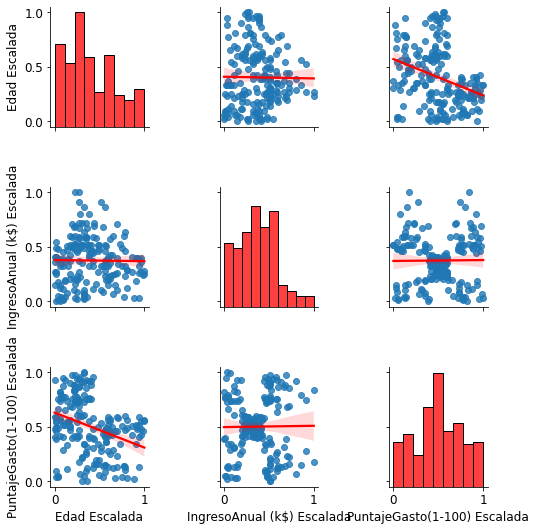

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size': 12})
columns = ["Edad Escalada","IngresoAnual (k$) Escalada", "PuntajeGasto(1-100) Escalada"]
sns.pairplot(datos[columns], kind='reg',
             plot_kws={'line_kws':{'color':'red'}}, diag_kws={'color':'red'})

Text(0.5, 0, 'PuntajeGasto(1-100) Escalada')

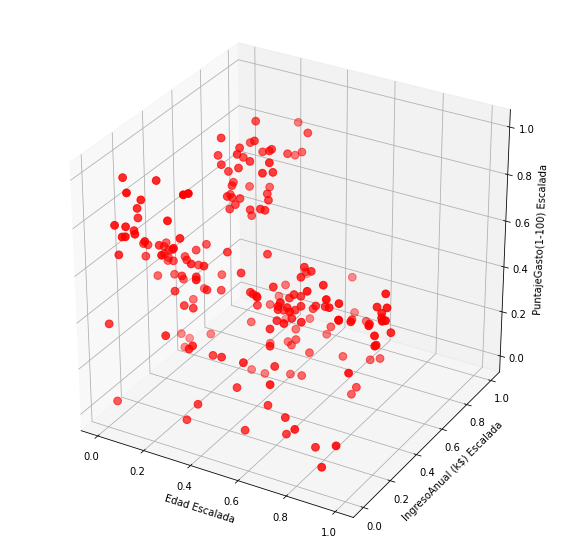

In [ ]:
# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


axis_list = ["Edad Escalada","IngresoAnual (k$) Escalada", "PuntajeGasto(1-100) Escalada"]
x, y, z = axis_list

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")
sc = ax.scatter(datos[x], datos[y], datos[z], s = 60, color='red')

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

In [ ]:
datosModelo = datos[["Edad Escalada", "IngresoAnual (k$) Escalada", "PuntajeGasto(1-100) Escalada"]].values

Función que define el algoritmo k-means y retorna el valor de inercia, centroides y el valor de silueta


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

def AlgoritmoK_Means(datosEntrada, n):
    clustering_KMeans = KMeans(n_clusters= n,init='k-means++', max_iter=300, random_state=0, algorithm = "elkan")
    clustering_KMeans.fit(datosEntrada)
    
    # create data frame to store centroids
    centroids  = clustering_KMeans.cluster_centers_
    
    # add cluster label for each data point
    label = clustering_KMeans.labels_
    datos["label"] = label
    
    # evaluation metrics for clustering - inertia and silhouette score
    inertia = clustering_KMeans.inertia_
    silhouette_score = metrics.silhouette_score(datosEntrada, label)
    
    return inertia, label, centroids, silhouette_score

Gráfica de segmentación de las observaciones final, para los 6 clusteres


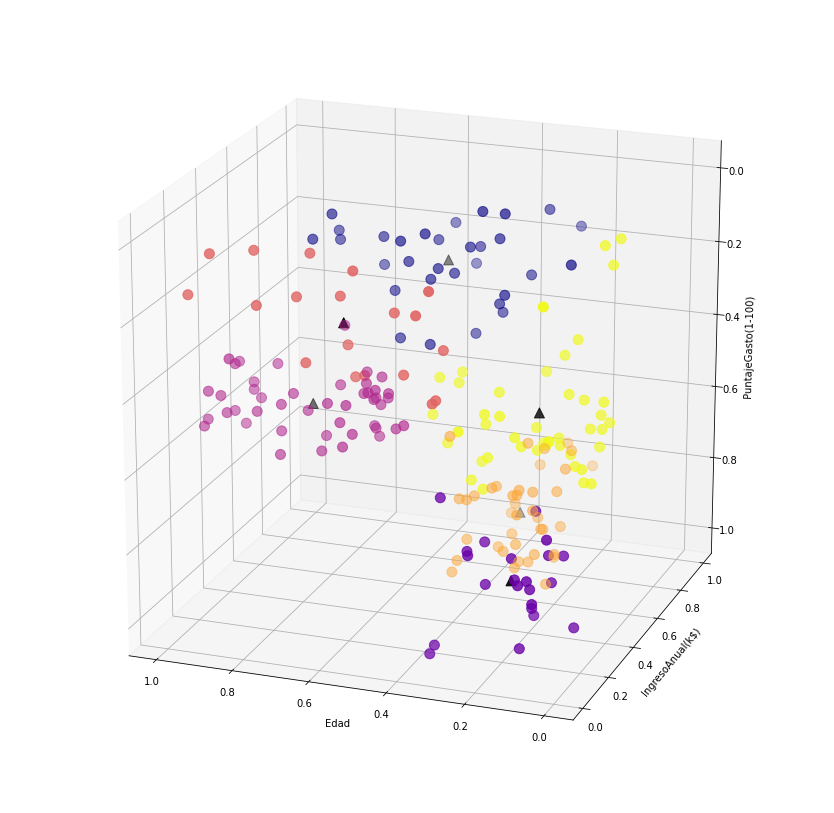

In [ ]:
Inertia_values = []
Silhouette_scores = []
fig = plt.figure(figsize=(50,50))
for i in range (6,7):
    Inertia, Label, Centroids, Silhouette = AlgoritmoK_Means(datosModelo, i)
    Inertia_values.append(Inertia)
    Silhouette_scores.append(Silhouette)
    centroids_datos= pd.DataFrame(Centroids, columns =['X', 'Y', 'Z'])
    ax = fig.add_subplot(330 + i - 1, projection='3d')
    ax.scatter(datos["Edad Escalada"],datos["IngresoAnual (k$) Escalada"],datos["PuntajeGasto(1-100) Escalada"], s = 100, c = datos["label"], cmap = "plasma")
    ax.scatter(centroids_datos['X'], centroids_datos['Y'], centroids_datos['Z'], s = 100, marker= "^", color = "black")
    ax.set_xlabel("Edad")
    ax.set_ylabel("IngresoAnual(k$)")
    ax.set_zlabel("PuntajeGasto(1-100)")
    ax.view_init(-160, 70)

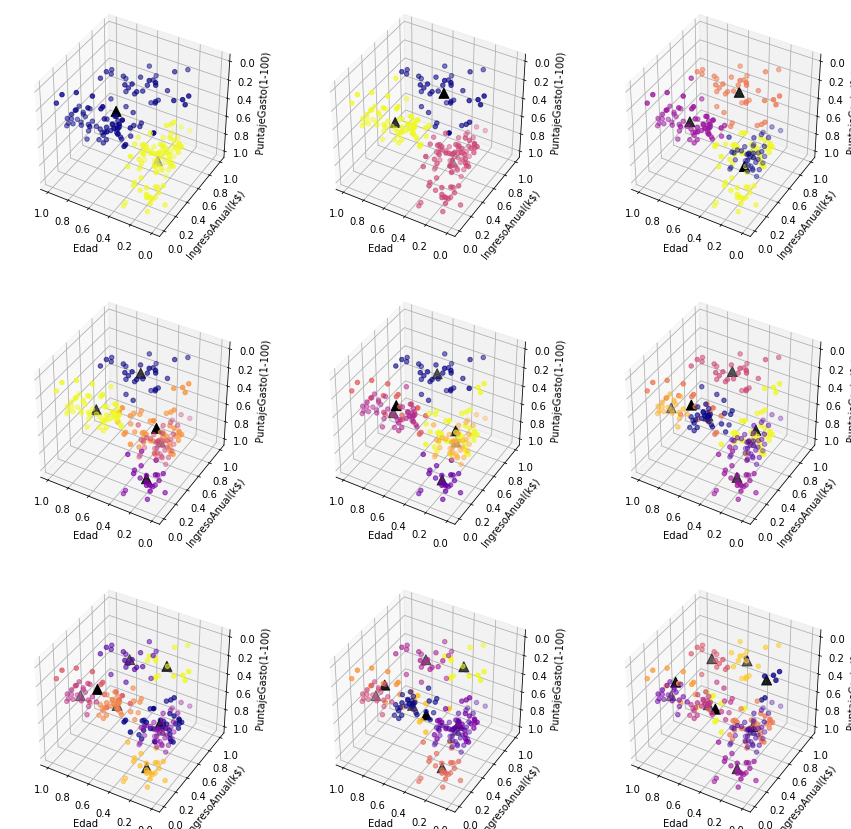

In [ ]:
# Spending vs. Age vs. Annual Income by different number of clusters
Inertia_values = []
Silhouette_scores = []
fig = plt.figure(figsize=(15,15))
for i in range (2,11):
    Inertia, Label, Centroids, Silhouette = AlgoritmoK_Means(datosModelo, i)
    Inertia_values.append(Inertia)
    Silhouette_scores.append(Silhouette)
    centroids_datos= pd.DataFrame(Centroids, columns =['X', 'Y', 'Z'])
    ax = fig.add_subplot(330 + i - 1, projection='3d')
    ax.scatter(datos["Edad Escalada"],datos["IngresoAnual (k$) Escalada"],datos["PuntajeGasto(1-100) Escalada"], s = 20, c = datos["label"], cmap = "plasma")
    ax.scatter(centroids_datos['X'], centroids_datos['Y'], centroids_datos['Z'], s = 100, marker= "^", color = "black")
    ax.set_xlabel("Edad")
    ax.set_ylabel("IngresoAnual(k$)")
    ax.set_zlabel("PuntajeGasto(1-100)")
    ax.view_init(-140, 60)

# plot inertia values against number of clusters


Text(0, 0.5, 'Silueta Score')

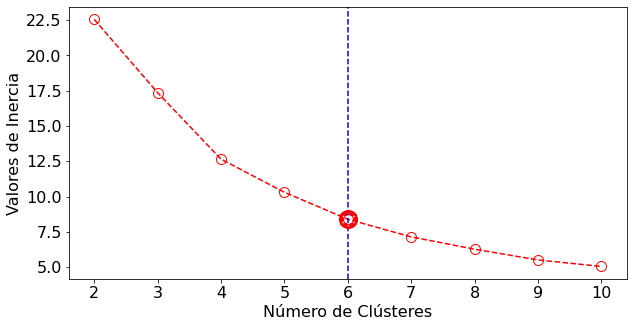

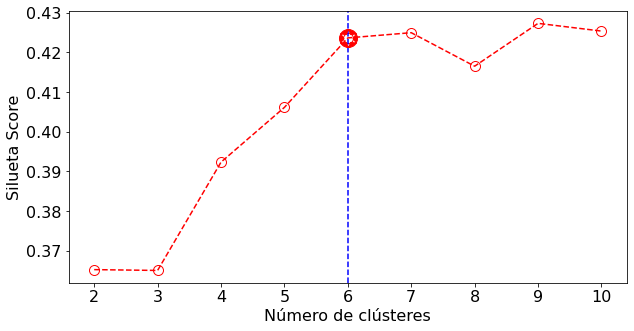

In [ ]:
import matplotlib.path as mpath
import numpy as np
plt.rcParams.update({'font.size': 16})
estrella = mpath.Path.unit_regular_star(6)
circulo = mpath.Path.unit_circle()
verts = np.concatenate([circulo.vertices, estrella.vertices[::-1, ...]])
codes = np.concatenate([circulo.codes, estrella.codes])
cut_star = mpath.Path(verts, codes)


plt.figure(11 , figsize = (10 ,5))
plt.plot(np.arange(2 , 11) , Inertia_values , '--r', marker="o", markersize=10, fillstyle='none')
plt.axvline(x=6, color='b', linestyle='--')
plt.plot(6, 8.39 , '--r', marker=cut_star, markersize=18)

plt.xlabel("Número de Clústeres")
plt.ylabel("Valores de Inercia")

# plot inertia values against number of clusters
plt.figure(12, figsize=(10,5))
plt.plot(np.arange(2,11) , Silhouette_scores , '--r', marker="o", markersize=10, fillstyle='none')
plt.axvline(x=6, color='b', linestyle='--')
plt.plot(6, 0.4236 , '--r', marker=cut_star, markersize=18)
plt.xlabel("Número de clústeres")
plt.ylabel("Silueta Score")

Graficamos la distribución de los valores de las variables distinguiendo por la variable dicotómica genero

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
!pip install plotly

import plotly.express as px

fig = plt.figure(figsize=(15,15))
variables_list = ["Genre","Edad Escalada","IngresoAnual (k$) Escalada", "PuntajeGasto(1-100) Escalada"]
ax = fig.add_subplot(projection='3d') 

sc = px.scatter_3d(datos, x=variables_list[1], y=variables_list[2], z=variables_list[3], color=variables_list[0],                 labels={
                     "Edad Escalada": "Edad",
                     "IngresoAnual (k$) Escalada": "IngresoAnual (k$)",
                     "PuntajeGasto (1-100) Escalada": "PuntajeGasto (1-100)"
                 },
                title="Distribución de datos según el género del cliente")
sc.update_traces(marker_size = 5)
#sc.update_layout(legend_traceorder="reversed")
sc.update_traces(showlegend=True)
sc.update_coloraxes(showscale=False)
sc.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
sc.update_layout(title='Distribución de datos escalados según la variable género', autosize=False, 
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

sc.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<IPython.core.display.Javascript object>